# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
# !pip install --upgrade matplotlib
# !pip install --upgrade pandas
# !pip install -U imbalanced-learn
# !pip install Pyarrow

## Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np

In [3]:
try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [4]:
display(df.head())
display(df.info())
df.describe()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Предоставленный датасет в хорошем качестве, размерность 10000х14, пропущенные значение только у столбца Tenure. Отсутствует примерно 10% значений.

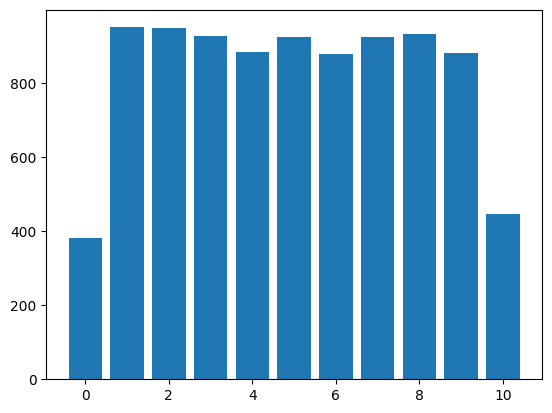

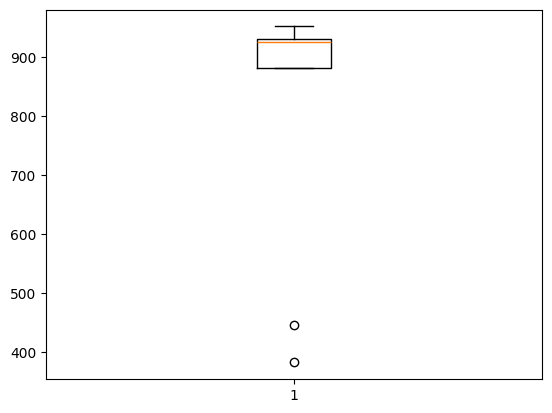

In [5]:
plt.bar(df['Tenure'].value_counts().index, df['Tenure'].value_counts());
plt.figure()
plt.boxplot(df['Tenure'].value_counts());

Клиентов, которые c банком до года и 10 лет в два раза меньше чем клиентов из других категорий. Заполним пропуски медианой, которая в нашем случае равна 5.

In [6]:
df.loc[(df['Tenure'].isna()), 'Tenure'] = int(df.Tenure.median())
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Теперь избавимся от лишних столбцов. Столбцы RowNumber, CustomerId и Surname явно не помогут нам в прогнозе.

In [7]:
df = df[[col for col in df.columns if col not in df.columns[:3]]]

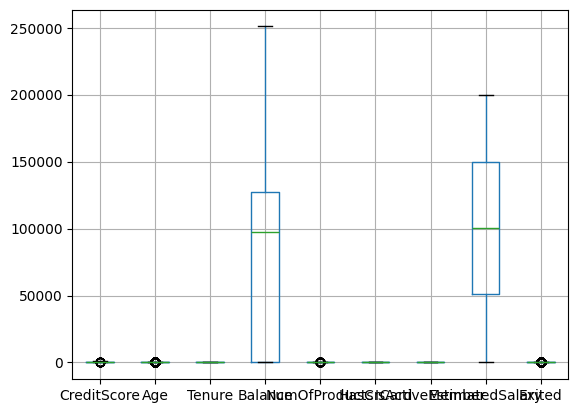

In [8]:
df.boxplot();

Результаты построения ящика с усами для всех численных столбцов говорят о том что значения надо стандартизовать. Но делать мы это будем после разбиения на тренировочную и тестовую выборки.

## Исследование задачи

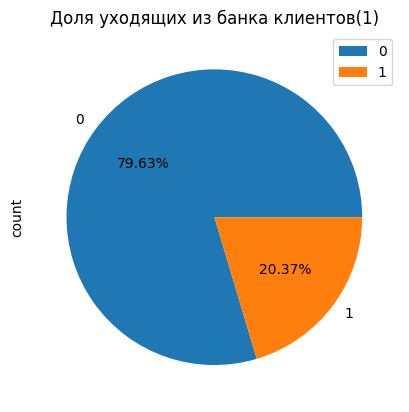

In [9]:
pd.DataFrame(df.Exited.value_counts()).plot.pie(y='count', autopct='%1.2f%%', 
                                                title='Доля уходящих из банка клиентов(1)');

Дисбаланс классов примерно 4 к 1, это умеренный дисбаланс.

In [10]:
pd.DataFrame(df.Exited.value_counts())

,count
Exited,
0,7963
1,2037


In [11]:
# Разбиваем данные на выборки
features = df.drop(['Exited'], axis=1)
target = df.Exited

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.4, random_state=112
)
features_test, features_val, target_test, target_val = train_test_split(
features_test, target_test, test_size=0.5, random_state=113
)    
# One Hot Encoder
coder = OneHotEncoder(drop='first')
coder.fit(features_train[['Geography', 'Gender']])

def encode_categorical(data, coder):
    converted = pd.DataFrame(coder.transform(data[['Geography', 'Gender']]).toarray(),
                             columns=coder.get_feature_names_out())
    data = data.drop(['Geography', 'Gender'], axis=1)
    data = pd.concat([data.reset_index(drop=True), converted.reset_index(drop=True)], axis=1)
    return data    

features_train = encode_categorical(features_train, coder)
features_test = encode_categorical(features_test, coder)
features_val = encode_categorical(features_val, coder)
# Scaling
var_numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 
               'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[var_numeric])
def scale_data(data, columns, scaler):
    data[columns] = scaler.transform(data[columns])
    return pd.DataFrame(data, columns=columns)
features_train[var_numeric] = scale_data(features_train, var_numeric, scaler)
features_test[var_numeric] = scale_data(features_test, var_numeric, scaler)
features_val[var_numeric] = scale_data(features_val, var_numeric, scaler)

In [12]:
# функция для поиска лучшей модели для решающего дерева и случайного леса
def get_best_model(range_, model_object, x_train, x_val, y_train, y_val):
    score = 0
    best_model = None
    df = {'F1': [], 'depth': []}
    for i in range(1, range_+1):
        model = model_object(random_state=7765, max_depth=i)
        model.fit(x_train, y_train)
        model_pred = model.predict(x_val)
        df['F1'].append(score_m := f1_score(y_val, model_pred))
        df['depth'].append(i)
        if score_m > score:
            score = score_m
            best_model = model
        #pd.DataFrame(df).style.background_gradient('coolwarm', subset=['F1'])
    display(pd.DataFrame(df).sort_values(by='F1', ascending=False).head(10))
    return best_model

In [13]:
best_model_d_tree = get_best_model(15, 
                                   DecisionTreeClassifier,
                                   features_train,
                                   features_test,
                                   target_train,
                                   target_test
                                   )

,F1,depth
6,0.579310,7
4,0.576320,5
8,0.567416,9
7,0.551111,8
5,0.550989,6
11,0.548602,12
10,0.539945,11
9,0.534459,10
12,0.532300,13
13,0.517286,14


Наилучший результат показала модель с глубиной 7. Посмотрим как покажет себя случайный лес.

In [14]:
best_model_r_forest = get_best_model(30,
                                   RandomForestClassifier,
                                   features_train,
                                   features_test,
                                   target_train,
                                   target_test
                                   )

,F1,depth
15,0.592920,16
21,0.586826,22
25,0.584337,26
14,0.582701,15
26,0.582583,27
17,0.582467,18
16,0.581709,17
18,0.580838,19
24,0.580451,25
20,0.579970,21


Лучше всего показала себя модель с глубиной равной 16. Посмотрим, удастся ли улучшить результат варьированием количества деревьев.

In [15]:
# модифицируем нашу функцию
def get_best_model_ne(range_, model_object, x_train, x_val, y_train, y_val, max_depth):
    score = 0
    best_model = None
    df_ = {'F1': [], 'n_estimators': []}
    range_ = range_+1
    for i in range(20, range_, 20):
        model = model_object(random_state=7765, max_depth=max_depth, n_estimators=i)
        model.fit(x_train, y_train)
        model_pred = model.predict(x_val)
        df_['F1'].append(score_m := f1_score(y_val, model_pred))
        df_['n_estimators'].append(i)
        if score_m > score:
            score = score_m
            best_model = model
        #pd.DataFrame(df).style.background_gradient('coolwarm', subset=['F1'])
    display(pd.DataFrame(df_).sort_values(by='F1', ascending=False).head(10))
    return best_model

best_model_r_forest_ne = get_best_model_ne(250,
                                     RandomForestClassifier,
                                     features_train,
                                     features_test,
                                     target_train,
                                     target_test,
                                     max_depth=16)

,F1,n_estimators
1,0.597633,40
2,0.596182,60
9,0.595556,200
11,0.594993,240
4,0.592920,100
0,0.591716,20
10,0.590842,220
3,0.590308,80
8,0.589286,180
7,0.588410,160


In [16]:
for estim in range(100, 201, 20):
    for depth in range(12, 21, 2):
        model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)

        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        probablities_test = model.predict_proba(features_test)[:, 1]

        print("n_estimators =", estim,
              "max_depth =", depth,
              'F1 =', f1_score(target_test, predicted_test),
              'AUC-ROC =', roc_auc_score(target_test, probablities_test)
         )

n_estimators = 100 max_depth = 12 F1 = 0.5809379727685325 AUC-ROC = 0.8609068599894163
n_estimators = 100 max_depth = 14 F1 = 0.5855855855855855 AUC-ROC = 0.8600253945981762
n_estimators = 100 max_depth = 16 F1 = 0.5880597014925373 AUC-ROC = 0.8555221258306835
n_estimators = 100 max_depth = 18 F1 = 0.5808383233532934 AUC-ROC = 0.8538056668630476
n_estimators = 100 max_depth = 20 F1 = 0.5896296296296296 AUC-ROC = 0.857718293854777
n_estimators = 120 max_depth = 12 F1 = 0.5718654434250765 AUC-ROC = 0.862031178090488
n_estimators = 120 max_depth = 14 F1 = 0.5714285714285714 AUC-ROC = 0.861569458123648
n_estimators = 120 max_depth = 16 F1 = 0.5854383358098068 AUC-ROC = 0.8566419466593511
n_estimators = 120 max_depth = 18 F1 = 0.5791044776119403 AUC-ROC = 0.8538506395870904
n_estimators = 120 max_depth = 20 F1 = 0.5878877400295421 AUC-ROC = 0.8580675820115099
n_estimators = 140 max_depth = 12 F1 = 0.5814307458143075 AUC-ROC = 0.8620176862732752
n_estimators = 140 max_depth = 14 F1 = 0.58093

По итогам предварительного анализа алгоритма случайного леса лучший результат показала модель на 40 деревьев, глубиной 16 ветвей.

In [17]:
# Проверим логистическую регрессию
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model_logistic = LogisticRegression(random_state=777, solver=solver)
    model_logistic.fit(features_train, target_train)
    model_pred = model_logistic.predict(features_test)
    print(f1_score(target_test, model_pred), solver)

0.28256880733944956 newton-cg
0.28256880733944956 lbfgs
0.28571428571428575 liblinear
0.28256880733944956 sag
0.28256880733944956 saga


Логистическая регрессия показывает наихудший результат.

              Classifier     Score
0          decision_tree  0.829332
1          random_forest  0.860731
2  random_forest_ne_prob  0.858088
3    logistic_regression  0.773576


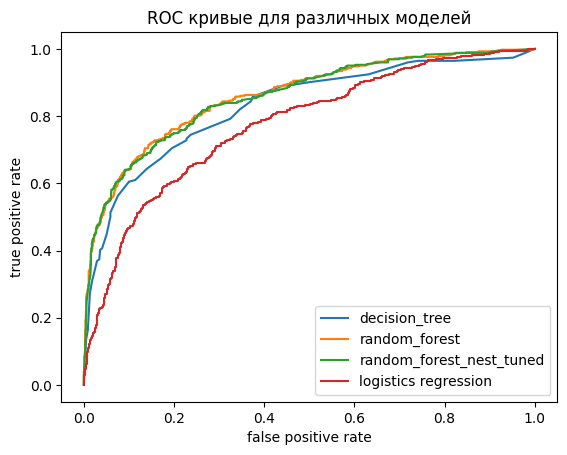

In [18]:
d_tree_prob = best_model_d_tree.predict_proba(features_test)[:,1]
r_forest_prob = best_model_r_forest.predict_proba(features_test)[:,1]
r_forest_ne_prob = best_model_r_forest_ne.predict_proba(features_test)[:,1]
logistic_prob = model_logistic.predict_proba(features_test)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривые для различных моделей')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_test, d_tree_prob)
decision_tree, = ax.plot(fpr, tpr, label='decision_tree')
fpr, tpr, threshold =  roc_curve(target_test, r_forest_prob)
random_forest, = ax.plot(fpr, tpr, label='random_forest')
fpr, tpr, threshold =  roc_curve(target_test, r_forest_ne_prob)
random_forest_nest_tuned, = ax.plot(fpr, tpr, label='random_forest_nest_tuned')
plt.plot()
fpr, tpr, threshold =  roc_curve(target_test, logistic_prob)
logistic_regression, = ax.plot(fpr, tpr, label='logistics regression')
ax.legend(handles=[decision_tree, random_forest, random_forest_nest_tuned, logistic_regression]);

AUC_scores = {'Classifier':[], 'Score':[]}
AUC_scores['Classifier'].append('decision_tree')
AUC_scores['Score'].append(roc_auc_score(target_test, d_tree_prob))
AUC_scores['Classifier'].append('random_forest')
AUC_scores['Score'].append(roc_auc_score(target_test, r_forest_prob))
AUC_scores['Classifier'].append('random_forest_ne_prob')
AUC_scores['Score'].append(roc_auc_score(target_test, r_forest_ne_prob))
AUC_scores['Classifier'].append('logistic_regression')
AUC_scores['Score'].append(roc_auc_score(target_test, logistic_prob))
print(pd.DataFrame(AUC_scores))

У всех алгоритмов площадь под кривой больше 0.5, а значит все работают лучше, чем модель, которая угадывает результат случайно. Лучший результат показали две модели на основе случайного леса. Небольшой неожиданностью стала то что модель, которая показала немного лучший результат на F1, повела себя хуже при измерении ROC-AUC. Однако, в обоих случаях разница на сотые и тысячные доли единицы.

ROC-AUC_score 0.8580878197373294


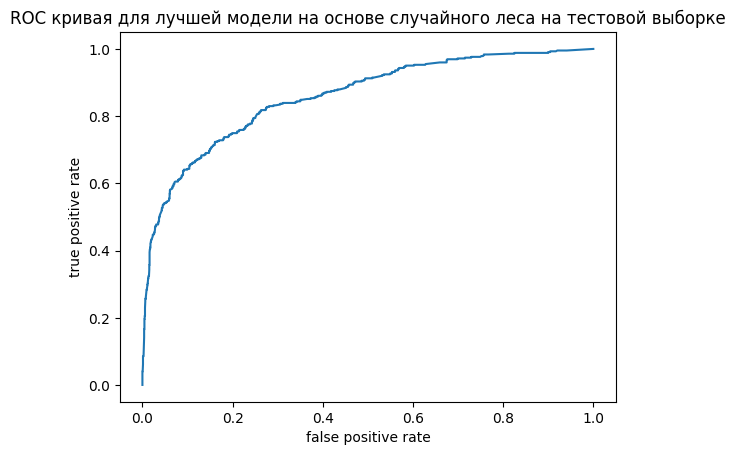

In [19]:
# Построим ROC кривую для лучшей модели на тестовой выборке.
r_forest_ne_prob = best_model_r_forest_ne.predict_proba(features_test)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривая для лучшей модели на основе случайного леса на тестовой выборке')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_test, r_forest_ne_prob)
random_forest_nest_tuned, = ax.plot(fpr, tpr, label='random_forest_nest_tuned')
plt.plot();

print('ROC-AUC_score',
      roc_auc_score(target_test, r_forest_ne_prob))

Подводя небольшой промежуточный итог можно сказать что мы вышли на целвой показатель F1 - 0.59 до методов оверсемплинга.

## Борьба с дисбалансом

Для борьбы с дисбалансом в классах я решил использовать популярный алгоритм the Synthetic Minority Oversampling Technique (SMOTE).

In [20]:
smote = SMOTE(random_state=12345)
features_train_r, target_train_r = smote.fit_resample(features_train, target_train)

Проверим данные на моделях, расширив диапазон поиска оптимальных значений.

In [21]:
best_model_d_tree = get_best_model(50,
                                   DecisionTreeClassifier,
                                   features_train_r,
                                   features_test,
                                   target_train_r,
                                   target_test
                                   )

,F1,depth
8,0.584711,9
7,0.584615,8
6,0.579651,7
5,0.569790,6
9,0.564604,10
3,0.559846,4
2,0.557110,3
10,0.550162,11
4,0.544564,5
11,0.542735,12


In [22]:
best_model_r_forest = get_best_model(50,
                                     RandomForestClassifier,
                                     features_train_r,
                                     features_test,
                                     target_train_r,
                                     target_test
                                     )

,F1,depth
7,0.642857,8
11,0.642599,12
9,0.642523,10
8,0.642438,9
14,0.638509,15
10,0.637647,11
12,0.637019,13
6,0.635104,7
18,0.629492,19
13,0.628221,14


In [23]:
best_model_r_forest_ne = get_best_model_ne(300,
                                           RandomForestClassifier,
                                           features_train_r,
                                           features_test,
                                           target_train_r,
                                           target_test,
                                           8)

,F1,n_estimators
3,0.643021,80
4,0.642857,100
6,0.640821,140
2,0.640091,60
1,0.639080,40
5,0.638540,120
12,0.637615,260
14,0.636156,300
11,0.636051,240
13,0.636051,280


In [24]:
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model_logistic = LogisticRegression(random_state=777, solver=solver)
    model_logistic.fit(features_train_r, target_train_r)
    model_pred = model_logistic.predict(features_test)
    print(f1_score(target_test, model_pred), solver)

0.5017857142857144 newton-cg
0.5017857142857144 lbfgs
0.5017857142857144 liblinear
0.5017857142857144 sag
0.5017857142857144 saga


Проверим лес другим алгоритмом.

In [25]:
for estim in range(100, 201, 20):
    for depth in range(12, 21, 2):
        model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)

        model.fit(features_train_r, target_train_r)
        predicted_test = model.predict(features_test)
        probablities_test = model.predict_proba(features_test)[:, 1]

        print("n_estimators =", estim,
              "max_depth =", depth,
              'F1 =', f1_score(target_test, predicted_test),
              'AUC-ROC =', roc_auc_score(target_test, probablities_test)
             )

n_estimators = 100 max_depth = 12 F1 = 0.6400937866354045 AUC-ROC = 0.8592833446514688
n_estimators = 100 max_depth = 14 F1 = 0.6305655836341757 AUC-ROC = 0.8567221480172273
n_estimators = 100 max_depth = 16 F1 = 0.6317073170731707 AUC-ROC = 0.8570159698143074
n_estimators = 100 max_depth = 18 F1 = 0.6403940886699508 AUC-ROC = 0.8608041722695187
n_estimators = 100 max_depth = 20 F1 = 0.6362515413070282 AUC-ROC = 0.8556705358200252
n_estimators = 120 max_depth = 12 F1 = 0.6360424028268551 AUC-ROC = 0.8597900373423518
n_estimators = 120 max_depth = 14 F1 = 0.6344993968636913 AUC-ROC = 0.857571382956237
n_estimators = 120 max_depth = 16 F1 = 0.6404907975460122 AUC-ROC = 0.8576051124992692
n_estimators = 120 max_depth = 18 F1 = 0.6360248447204969 AUC-ROC = 0.861169950425067
n_estimators = 120 max_depth = 20 F1 = 0.6311881188118812 AUC-ROC = 0.8566441952955531
n_estimators = 140 max_depth = 12 F1 = 0.6366863905325444 AUC-ROC = 0.8604901127466191
n_estimators = 140 max_depth = 14 F1 = 0.6366

Лучше всего показала себя модель с максимальной глубиной 8 и 80 деревьями. Запомним эти цифры.

ROC-AUC_score 0.8578029924850579


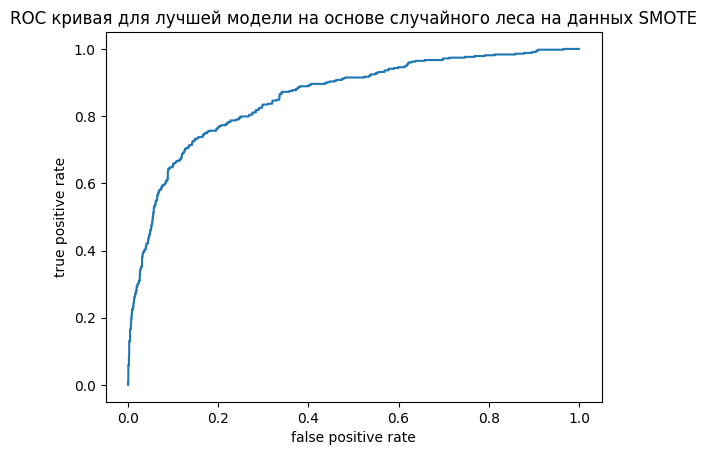

In [26]:
# Построим ROC кривую для модели на тестовой выборке.
model = RandomForestClassifier(random_state=7765, n_estimators=80, max_depth=8)
model.fit(features_train_r, target_train_r)

random_forest_prob = model.predict_proba(features_test)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривая для лучшей модели на основе случайного леса на данных SMOTE')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_test, random_forest_prob)
rf_tuned, = ax.plot(fpr, tpr, label='rf_tuned')
plt.plot();

print('ROC-AUC_score',
      roc_auc_score(target_test, random_forest_prob))

Модель показывает неплохой результат и площадь под кривой занимает более 80% на графике.

Попробуем другой метод борьбы с несбалансированной выборкой.

In [27]:
adasyn = ADASYN(random_state=442)
features_train_r, target_train_r = adasyn.fit_resample(features_train, target_train)

In [28]:
best_model_d_tree = get_best_model(40,
                                   DecisionTreeClassifier,
                                   features_train_r,
                                   features_test,
                                   target_train_r,
                                   target_test
                                   )

,F1,depth
6,0.583421,7
7,0.577465,8
3,0.571116,4
5,0.567669,6
8,0.565079,9
4,0.558325,5
9,0.550155,10
11,0.524168,12
10,0.521645,11
12,0.517497,13


In [29]:
best_model_r_forest = get_best_model(40,
                                     RandomForestClassifier,
                                     features_train_r,
                                     features_test,
                                     target_train_r,
                                     target_test
                                     )

,F1,depth
8,0.637874,9
9,0.631101,10
10,0.630385,11
12,0.629371,13
13,0.629240,14
7,0.628821,8
15,0.628099,16
11,0.627451,12
14,0.626651,15
5,0.625793,6


In [30]:
best_model_r_forest_ne = get_best_model_ne(300,
                                           RandomForestClassifier,
                                           features_train_r,
                                           features_test,
                                           target_train_r,
                                           target_test,
                                           9)

,F1,n_estimators
8,0.639381,180
5,0.638581,120
7,0.638581,160
4,0.637874,100
6,0.637874,140
3,0.637266,80
9,0.637266,200
11,0.636564,240
12,0.636564,260
13,0.636564,280


In [31]:
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model_logistic = LogisticRegression(random_state=777, solver=solver)
    model_logistic.fit(features_train_r, target_train_r)
    model_pred = model_logistic.predict(features_test)
    print(f1_score(target_test, model_pred), solver)

0.49823321554770317 newton-cg
0.49823321554770317 lbfgs
0.49690539345711754 liblinear
0.49823321554770317 sag
0.49823321554770317 saga


In [32]:
# Посмотрим что покажет альтернативный алгоритм случайного леса
for estim in range(100, 201, 20):
    for depth in range(12, 21, 2):
        model = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)

        model.fit(features_train_r, target_train_r)
        predicted_test = model.predict(features_test)
        probablities_test = model.predict_proba(features_test)[:, 1]

        print("n_estimators =", estim,
              "max_depth =", depth,
              'F1 =', f1_score(target_test, predicted_test),
              'AUC-ROC =', roc_auc_score(target_test, probablities_test)
             )

n_estimators = 100 max_depth = 12 F1 = 0.6277205040091639 AUC-ROC = 0.8539405850351762
n_estimators = 100 max_depth = 14 F1 = 0.6296296296296295 AUC-ROC = 0.8541197263859469
n_estimators = 100 max_depth = 16 F1 = 0.6183115338882283 AUC-ROC = 0.8486607872325436
n_estimators = 100 max_depth = 18 F1 = 0.6254458977407847 AUC-ROC = 0.8531265787300004
n_estimators = 100 max_depth = 20 F1 = 0.6239419588875454 AUC-ROC = 0.8518710901838036
n_estimators = 120 max_depth = 12 F1 = 0.6321839080459771 AUC-ROC = 0.8543588313687748
n_estimators = 120 max_depth = 14 F1 = 0.6281755196304849 AUC-ROC = 0.8552410463054158
n_estimators = 120 max_depth = 16 F1 = 0.6230677764565993 AUC-ROC = 0.8498668057822929
n_estimators = 120 max_depth = 18 F1 = 0.6276849642004773 AUC-ROC = 0.8533169632617817
n_estimators = 120 max_depth = 20 F1 = 0.6209386281588447 AUC-ROC = 0.8531625569092347
n_estimators = 140 max_depth = 12 F1 = 0.629418472063854 AUC-ROC = 0.8549749576881622
n_estimators = 140 max_depth = 14 F1 = 0.628

Получились неплохие результаты, рекорд удерживает алгоритм случайного леса с F1 = 0.643021 на данных SMOTE.

              Classifier     Score
0          decision_tree  0.812928
1          random_forest  0.851981
2  random_forest_ne_prob  0.852695
3    logistic_regression  0.759610


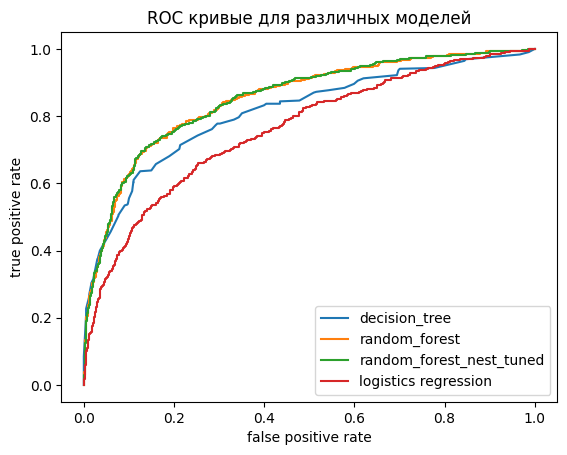

In [33]:
d_tree_prob = best_model_d_tree.predict_proba(features_test)[:,1]
r_forest_prob = best_model_r_forest.predict_proba(features_test)[:,1]
r_forest_ne_prob = best_model_r_forest_ne.predict_proba(features_test)[:,1]
logistic_prob = model_logistic.predict_proba(features_test)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривые для различных моделей')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_test, d_tree_prob)
decision_tree, = ax.plot(fpr, tpr, label='decision_tree')
fpr, tpr, threshold =  roc_curve(target_test, r_forest_prob)
random_forest, = ax.plot(fpr, tpr, label='random_forest')
fpr, tpr, threshold =  roc_curve(target_test, r_forest_ne_prob)
random_forest_nest_tuned, = ax.plot(fpr, tpr, label='random_forest_nest_tuned')
fpr, tpr, threshold =  roc_curve(target_test, logistic_prob)
logistic_regression, = ax.plot(fpr, tpr, label='logistics regression')
ax.legend(handles=[decision_tree, random_forest, random_forest_nest_tuned, logistic_regression]);

AUC_scores = {'Classifier':[], 'Score':[]}
AUC_scores['Classifier'].append('decision_tree')
AUC_scores['Score'].append(roc_auc_score(target_test, d_tree_prob))
AUC_scores['Classifier'].append('random_forest')
AUC_scores['Score'].append(roc_auc_score(target_test, r_forest_prob))
AUC_scores['Classifier'].append('random_forest_ne_prob')
AUC_scores['Score'].append(roc_auc_score(target_test, r_forest_ne_prob))
AUC_scores['Classifier'].append('logistic_regression')
AUC_scores['Score'].append(roc_auc_score(target_test, logistic_prob))
print(pd.DataFrame(AUC_scores))

Модели на основе случайного леса достаточно близки, на втором месте решающее дерево, логистическая регрессия хуже всех.

ROC-AUC_score 0.8526948405791888


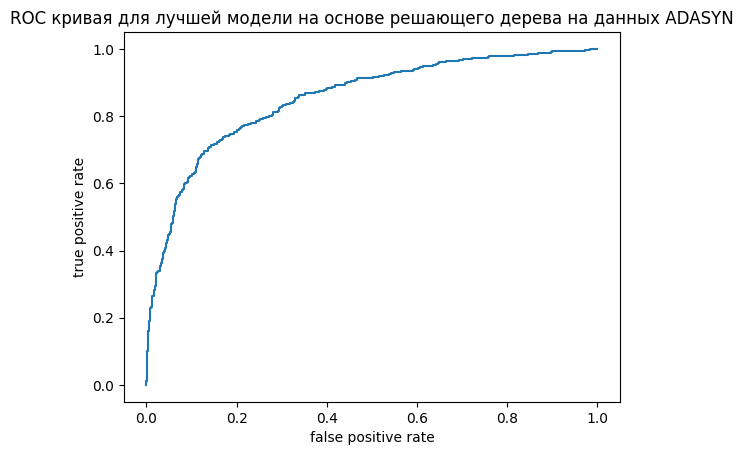

In [34]:
# Построим ROC кривую для лучшей модели на данных ADASYN.
rf_prob = best_model_r_forest_ne.predict_proba(features_test)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривая для лучшей модели на основе решающего дерева на данных ADASYN')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_test, rf_prob)
rf_tuned, = ax.plot(fpr, tpr, label='rf_tuned')
plt.plot();

print('ROC-AUC_score',
      roc_auc_score(target_test, rf_prob))

Наилучшая модель на базе решающего дерева. Установленный порог в 0.59 преодолён. Результат чуть хуже чем на данных SMOTE.

## Тестирование модели

Проверим модель на адекватность сравнением с моделью которая случайным образом угадывает 0 или 1. Пусть одна модель будет равновероятная, а вторая будет с вероятностью 1 угадывать 1. А также проверим модель на валидационной выборке.

In [35]:
fifty_fifty = np.random.choice([1, 0], 2000, p=[1/2, 1/2])
one = np.random.choice([1, 0], 2000, p=[1, 0])

smote = SMOTE(random_state=12345)
features_train_r, target_train_r = smote.fit_resample(features_train, target_train)
model = RandomForestClassifier(random_state=7765, n_estimators=80, max_depth=8)
model.fit(features_train_r, target_train_r)
best_model_predict = model.predict(features_val)

print('fifty_fifty', f1_score(target_val, fifty_fifty))
print('one', f1_score(target_val, one))
print('best model', f1_score(target_val, best_model_predict))

fifty_fifty 0.3048433048433048
one 0.33679833679833676
best model 0.6016260162601625


Самой хорошей моделью оказалась модель на базе решающих деревьев с параметрами n_est = 80 и max_depth = 8.

Построим ROC кривые для модели на валидационных данных и для абсурдных моделей.

ROC-AUC_score 0.5149451857448457


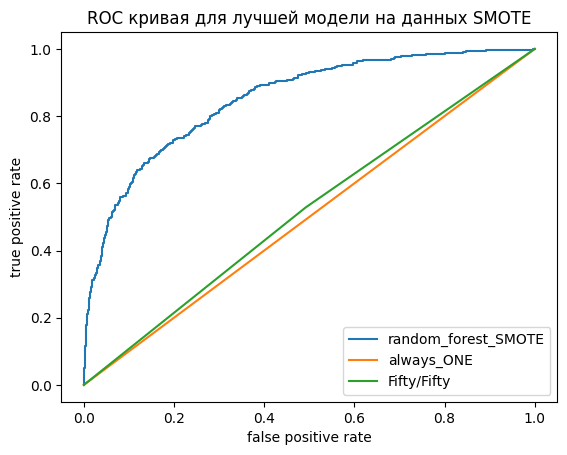

In [36]:
# Построим ROC кривую для лучшей модели на данных ADASYN.
rf_prob = model.predict_proba(features_val)[:,1]

fig = plt.figure()
ax = fig.add_subplot()
plt.title('ROC кривая для лучшей модели на данных SMOTE')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
fpr, tpr, threshold =  roc_curve(target_val, rf_prob)
rf_tuned = ax.plot(fpr, tpr, label='random_forest_SMOTE')
plt.plot();
fpr, tpr, threshold =  roc_curve(target_val, one)
rf_tuned = ax.plot(fpr, tpr, label='always_ONE')
plt.plot()
fpr, tpr, threshold =  roc_curve(target_val, fifty_fifty)
rf_tuned = ax.plot(fpr, tpr, label='Fifty/Fifty')
plt.plot()
ax.legend()


print('ROC-AUC_score',
      roc_auc_score(target_test, rf_prob))

На графике видно что модель проходит проверку на адекватность.

## Вывод

Для работы был предоставлен датасет в достаточно хорошем состоянии. 3 столбца с Фамилией, номером пользователя и.т.п. оказались лишними. В столбце "Tenure" было 10 процентов пропущенных значений, которые были заполнены медианой. Затем данные были стандартизованы.
После предварительных преобразований была посчитана доля уходящих клиентов в выборке, их оказалось 20%, это говорит о том что данные не сбалансированы. После этого расчёта были предварительно прогнаны модели DecisionTreeClassifier, RandomForestClassifier и LogisticRegression, преодолеть планку в F1 >= 0.59 удалось преодолеть без балансировки. Лучше всего себя показала модель на основе случайного леса.
Следующим этапом работы была балансировка и повторный прогон тех же моделей. Балансировка проводилась двумя методами: SMOTE и ADASYN. Результаты близки, но оверсемплинг SMOTE лучший результат. F1 на валидационной выборке у лучшей модели составила 0.6. Площадь под ROC кривыми у моделей на основе случайного леса всегда более 80.
На этапе тестирования модели была проведена проверка на адекватность и валидация на валидационных данных.
В итоге лучшей моделью оказалась модель на основе RandomForestClassifier глубиной в 8 ветвей и количеством деревьев 80, натренированной на оверсемпленных при помощи алгоритма SMOTE данных.